Importing all the necessary packages

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import sequential
from tensorflow.python.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
from tensorflow.python.keras.losses import categorical_crossentropy

Read in the data

In [3]:
df = pd.read_csv('finalData.csv')

C:\Users\ermun\AppData\Local\Temp\ipykernel_158524\941635897.py:1: DtypeWarning: Columns (15,21,23,40,42,47,48,52,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('finalData.csv')


Filter out data from 2014-2017 since the data is not complete for those years


In [4]:
df_filtered = df[(df['season_x'] > 2017)]

Filter by the 10 drivers to include in the network


In [5]:
drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

Target Variables to include in the model

In [6]:
targetVariables = ['race_lap_len', 'race_track_surface', 'race_track_name', 
                   'finish_position', 'starting_position', 'driver_id', 'driver_name', 'driver_nationality', 'driver_number', 'race_laps_lead', 'points_earned', 'playoff_points_earned',
                   'race_laps_run', 'race_status', 'race_cautions', 'race_speed', 'race_lead_changes', 'race_date', 'number_of_leaders', 'race_car_count', 'race_pole_time', 'race_miles_completed', 'race_purse_completed',
                   'car', 'owner_id', 'sponsor', 'race_winner_name', 'race_winner_real_id', 'race_winner_starting_pos', 'race_winner_make', 'restrictor_plate', 'pole_winner_speed', 'race_speed', 'race_lap_len', 'number_of_caution_laps']

Filter the DataFrame to only include the target variables


In [7]:
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

Filter out NTT, DFP, and MQ from 'race_pole_time' column


In [8]:
df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)
print(df_filtered.shape)
df_filtered = df_filtered.dropna(subset='race_pole_time')
print(df_filtered)

(1983, 82)
       season_x series_id_x                       race_id race_id_short  \
5947       2018           W              2018_DAYTONA_500       2018_01   
5948       2018           W              2018_DAYTONA_500       2018_01   
5951       2018           W              2018_DAYTONA_500       2018_01   
5962       2018           W              2018_DAYTONA_500       2018_01   
5963       2018           W              2018_DAYTONA_500       2018_01   
...         ...         ...                           ...           ...   
15482      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15489      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15493      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15495      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15499      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   

       finish_position  starting_position  driver_number driver_nationality  \
5947     

Define the X and y variables


In [50]:
X_target = df_filtered[targetVariables]
y = df_filtered['winner']
X_target

,race_lap_len,race_track_surface,race_track_name,finish_position,starting_position,driver_id,driver_name,driver_nationality,driver_number,race_laps_lead,...,sponsor,race_winner_name,race_winner_real_id,race_winner_starting_pos,race_winner_make,restrictor_plate,pole_winner_speed,race_speed,race_lap_len,number_of_caution_laps
5947,2.5,P,Daytona,3,2,Denny_Hamlin,Denny Hamlin,usa,11,22,...,FedEx Express,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5948,2.5,P,Daytona,4,5,Joey_Logano,Joey Logano,usa,22,3,...,Shell / Pennzoil,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5951,2.5,P,Daytona,7,3,Ryan_Blaney,Ryan Blaney,usa,12,118,...,Menards / Peak,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5962,2.5,P,Daytona,18,24,Martin_Truex_Jr,Martin Truex Jr,usa,78,4,...,Bass Pro Shops / 5-hour Energy,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
5963,2.5,P,Daytona,19,38,Kyle_Larson,Kyle Larson,usa,42,0,...,Credit One Bank,Austin Dillon,dilloau01,14,Chevrolet,True,195.644,150.545,2.5,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,1.0,P,Phoenix,4,4,Kyle_Larson,Kyle Larson,usa,5,13,...,HendrickCars.com (Rick Hendrick),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15489,1.0,P,Phoenix,11,14,Denny_Hamlin,Denny Hamlin,usa,11,0,...,FedEx (Joe Gibbs),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15493,1.0,P,Phoenix,15,27,Brad_Keselowski,Brad Keselowski,usa,6,0,...,BuildSubmarines.com (Jack Roush),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0
15495,1.0,P,Phoenix,17,1,Martin_Truex_Jr,Martin Truex Jr,usa,19,9,...,Bass Pro Shops (Joe Gibbs),Joey Logano,loganjo01,2,Ford,False,134.741,106.203,1.0,33.0


In [ ]:
# Categorical variables to include in the model
X_categorical = X_target[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X_categorical)



# Continuous variables to include in the model
X_continuous = X_target[['race_pole_time', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)



# Discrete variables to include in the model
X_discrete = X_target[['starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
X_discrete = scaler.fit_transform(X_discrete)


# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = np.concatenate((X_categorical, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)


In [52]:
print(X_stacked.shape, y.shape)
#df_stacked = X_stacked.dropna()
#print(df_stacked.shape, y.shape)

###
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_stacked, y, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Number of Nodes to have in the network
print(X_stacked.shape[1])
#400 with these specific features

#Verified there are no NA values in the dataset
print(X_stacked.isna().sum().sum())


(1382, 398) (1382,)
398
0


In [70]:
X_train = X_train_resampled
y_train = y_train_resampled

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)
X_val


,0,1,2,3,4,5,6,7,8,9,...,388,389,390,391,392,393,394,395,396,397
1667,1.0,0.0,0.000000,0.0,0.562750,0.0,0.43725,0.000000,0.0,0.0,...,0.155281,-1.072541,2.052342,-0.223326,2.049183,-1.012013,-0.221907,-0.512263,-0.808823,2.875188
480,1.0,0.0,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,1.110881,0.546097,-0.473075,-1.672928,-1.994140,0.985514,0.506383,1.585574,0.414480,-0.430666
905,1.0,0.0,1.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,-0.218882,0.659196,-0.473075,0.103145,0.610034,-0.013249,-0.326044,0.093735,-0.146200,-0.321555
1151,1.0,0.0,0.990929,0.0,0.000000,0.0,0.00000,0.009071,0.0,0.0,...,1.110881,-0.359717,-0.472386,-0.768670,1.561386,-0.010230,-0.826256,-1.142699,-0.702257,0.270022
29,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1.0,0.0,...,-0.218882,-0.697987,0.514752,0.086700,1.500936,0.985514,0.922597,1.336934,0.465451,0.093068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,1.000000,0.0,0.0,...,-0.218882,-0.245592,-0.397088,0.086700,0.335911,0.319672,-0.076316,0.093735,0.465451,-0.408844
194,1.0,0.0,0.000000,0.0,0.000000,0.0,1.00000,0.000000,0.0,0.0,...,1.323643,0.432999,0.134819,-0.562883,-0.760584,-1.012013,4.252306,3.574692,-0.961735,-0.430666
781,1.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,1.0,0.0,...,-0.218882,-1.037282,0.514752,0.086700,0.404441,-0.013249,0.090170,-0.652185,-0.095229,-0.408844
1981,1.0,0.0,0.000000,0.0,1.000000,0.0,0.00000,0.000000,0.0,0.0,...,-0.218882,0.331387,0.058832,0.148570,0.824795,-0.566926,0.348352,0.037888,-0.614745,0.996539


In [71]:
# Ensure required packages are installed
#%pip install tensorflow keras

import tensorflow as tf
from tensorflow import keras
from keras import layers
model = keras.Sequential()
model.add(layers.Dense(64, input_dim = 398, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)


print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)


Fit model on training data
Epoch 1/5


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - binary_accuracy: 0.5950 - loss: 0.6638 - val_binary_accuracy: 0.8329 - val_loss: 0.5160
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8616 - loss: 0.4627 - val_binary_accuracy: 0.8838 - val_loss: 0.3416
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9160 - loss: 0.2968 - val_binary_accuracy: 0.9346 - val_loss: 0.2213
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.9370 - loss: 0.2057 - val_binary_accuracy: 0.9467 - val_loss: 0.1697
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9611 - loss: 0.1472 - val_binary_accuracy: 0.9613 - val_loss: 0.1330


In [55]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)
print(predictions)
print(y_test[:10]) 


Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.9005 - loss: 0.2037
test loss, test acc: [0.2079702466726303, 0.9025270938873291]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
predictions shape: (10, 1)
[[4.6580436e-04]
 [2.1125011e-04]
 [4.1566822e-01]
 [5.4021847e-01]
 [1.5923560e-02]
 [1.1895585e-03]
 [4.3048008e-04]
 [4.0344542e-01]
 [1.3882120e-03]
 [2.1217049e-03]]
7550     0
12175    0
7345     0
12624    0
12375    0
11734    0
6333     0
6867     1
12226    0
8427     0
Name: winner, dtype: int64


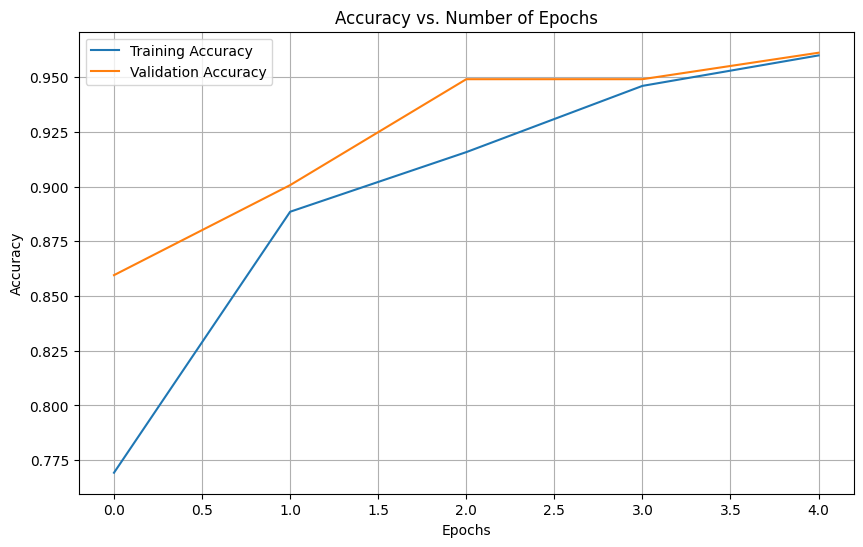

In [56]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)


I need to change my Y matrix from a single column (binary classification) to a matrix with mulitple dimensions (multi-class classification)

In [57]:
df_filtered = df[(df['season_x'] > 2017)]
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)

df_filtered = df_filtered.dropna(subset='race_pole_time')


df_filtered

C:\Users\ermun\AppData\Local\Temp\ipykernel_158524\2404990570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)


,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


In [58]:
one_hot_encoded_df = df_filtered.pivot_table(index='race_id_short', columns='driver_id', values='winner', fill_value=0)

In [59]:
one_hot_encoded_df

driver_id,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
race_id_short,,,,,,,,
2018_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024_32,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024_33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024_34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
df_filtered

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


This represents the full multiclass dataset that can me used for a multi-class classification network.

In [61]:
fullDataEncoded = df_filtered.join(one_hot_encoded_df, on='race_id_short')
fullDataEncoded

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,track_name,winner,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Categorical variables to include in the model
X_categorical = fullDataEncoded[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X_categorical)

# Continuous variables to include in the model
X_continuous = fullDataEncoded[['race_pole_time', 'race_speed', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)

# Discrete variables to include in the model
X_discrete = fullDataEncoded[['finish_position', 'starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'playoff_points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
X_discrete = scaler.fit_transform(X_discrete)

# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = np.concatenate((X_categorical, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)

y_multiClass = fullDataEncoded[['Brad_Keselowski',	'Denny_Hamlin',	'Joey_Logano',	'Kyle_Busch',	'Kyle_Larson',	'Martin_Truex_Jr',	'Ryan_Blaney',	'William_Byron']]
#y_multiClass

In [63]:
X_stacked = np.array(X_stacked)
print(X_stacked.shape[1])
y_multiClass = np.array(y_multiClass)

X_trainM, X_testM, y_trainM, y_testM = train_test_split(X_stacked, y_multiClass, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_trainM_resampled, y_trainM_resampled = smote.fit_resample(X_trainM, y_trainM)

X_trainMF, X_valMF, y_trainMF, y_valMF = train_test_split(X_trainM_resampled, y_trainM_resampled, random_state=42)


397


Use the new oneHotEncoded Y matrix to create a multi-class classification network

In [64]:
model2 = keras.Sequential()
model2.add(layers.Dense(64, input_dim = X_stacked.shape[1], activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(8, activation='softmax'))

model2.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)


print("Fit model on training data")
history = model2.fit(
    X_trainMF,
    y_trainMF,
    batch_size=64,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_valMF, y_valMF),
)

Fit model on training data
Epoch 1/30


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.1357 - loss: 0.5995 - val_categorical_accuracy: 0.1953 - val_loss: 0.3756
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2356 - loss: 0.3618 - val_categorical_accuracy: 0.4327 - val_loss: 0.3270
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4878 - loss: 0.3153 - val_categorical_accuracy: 0.5822 - val_loss: 0.2871
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6216 - loss: 0.2756 - val_categorical_accuracy: 0.6757 - val_loss: 0.2492
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7168 - loss: 0.2364 - val_categorical_accuracy: 0.7280 - val_loss: 0.2143
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7730 - loss: 0.1973 - val_categorical_accuracy: 0.7561 - val_loss: 0.1837
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7974 - loss: 0.1685 - val_categoric

Create a visualization that shows the improvement of accuracy over each epoch.

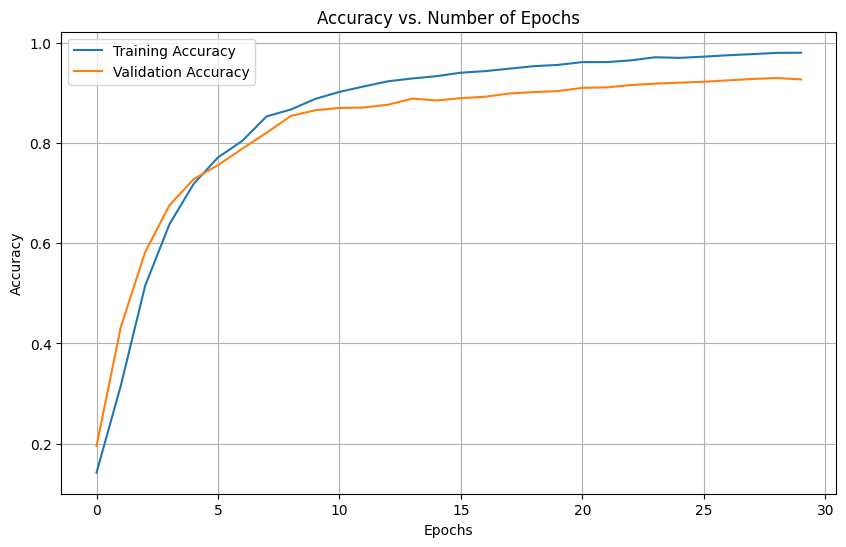

In [65]:

# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_accuracy(history)

In [66]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results2 = model2.evaluate(X_testM, y_testM, batch_size=128)
print("test loss, test acc:", results2)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions2 = model2.predict(X_valMF[:3])
print("predictions shape:", predictions2.shape)
print(predictions2)
print(y_valMF[:3]) 

Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.5130 - loss: 0.3696 
test loss, test acc: [0.3566579818725586, 0.5162454843521118]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
predictions shape: (3, 8)
[[4.5933710e-05 9.9993742e-01 9.8345265e-10 5.7951765e-06 7.1501116e-10
  1.9795077e-06 8.8201032e-06 9.6788532e-12]
 [2.2758647e-04 4.4306630e-06 5.3653399e-05 9.9745613e-01 2.5932794e-09
  2.2578770e-03 3.7949602e-07 3.1084041e-10]
 [2.9319845e-05 5.0808607e-10 3.0157202e-05 5.2412874e-09 1.0149417e-07
  2.2468707e-09 9.8155049e-08 9.9994028e-01]]
[[0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


In [26]:
import shap 
explainer1 = shap.KernelExplainer(model.predict, shap.sample(X_train, 3))

shap_values1 = explainer1.shap_values(X_val)

C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|          | 0/413 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  0%|          | 1/413 [00:00<04:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  0%|          | 2/413 [00:01<04:11,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


  1%|          | 3/413 [00:01<04:06,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 4/413 [00:02<04:07,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


  1%|          | 5/413 [00:03<04:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


  1%|▏         | 6/413 [00:03<03:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 7/413 [00:04<03:54,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 8/413 [00:04<03:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 9/413 [00:05<03:49,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 10/413 [00:05<04:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 11/413 [00:06<04:01,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


  3%|▎         | 12/413 [00:07<03:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 13/413 [00:07<03:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 14/413 [00:08<03:47,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▎         | 15/413 [00:08<03:43,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 16/413 [00:09<03:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


  4%|▍         | 17/413 [00:09<03:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


  4%|▍         | 18/413 [00:10<03:35,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


  5%|▍         | 19/413 [00:10<03:37,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


  5%|▍         | 20/413 [00:11<03:36,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▌         | 21/413 [00:12<03:43,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  5%|▌         | 22/413 [00:12<03:49,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 23/413 [00:13<03:50,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 24/413 [00:13<03:50,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  6%|▌         | 25/413 [00:14<03:46,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


  6%|▋         | 26/413 [00:15<03:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  7%|▋         | 27/413 [00:15<03:36,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


  7%|▋         | 28/413 [00:16<03:34,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


  7%|▋         | 29/413 [00:16<03:32,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  7%|▋         | 30/413 [00:17<03:35,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 31/413 [00:17<03:40,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  8%|▊         | 32/413 [00:18<03:41,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


  8%|▊         | 33/413 [00:19<03:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


  8%|▊         | 34/413 [00:19<03:35,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


  8%|▊         | 35/413 [00:20<03:32,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▊         | 36/413 [00:20<03:30,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


  9%|▉         | 37/413 [00:21<03:28,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  9%|▉         | 38/413 [00:21<03:30,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


  9%|▉         | 39/413 [00:22<03:29,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|▉         | 40/413 [00:22<03:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


 10%|▉         | 41/413 [00:23<03:32,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 10%|█         | 42/413 [00:24<03:31,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 10%|█         | 43/413 [00:24<03:30,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█         | 44/413 [00:25<03:29,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 11%|█         | 45/413 [00:25<03:26,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 11%|█         | 46/413 [00:26<03:37,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 11%|█▏        | 47/413 [00:27<03:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 48/413 [00:27<03:33,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 49/413 [00:28<03:33,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 50/413 [00:28<03:34,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 12%|█▏        | 51/413 [00:29<03:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 13%|█▎        | 52/413 [00:29<03:31,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 53/413 [00:30<03:28,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 13%|█▎        | 54/413 [00:31<03:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 55/413 [00:31<03:29,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▎        | 56/413 [00:32<03:33,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 57/413 [00:32<03:30,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 14%|█▍        | 58/413 [00:33<03:29,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 59/413 [00:34<03:29,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▍        | 60/413 [00:34<03:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 15%|█▍        | 61/413 [00:35<03:26,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


 15%|█▌        | 62/413 [00:35<03:23,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 15%|█▌        | 63/413 [00:36<03:21,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 15%|█▌        | 64/413 [00:36<03:19,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


 16%|█▌        | 65/413 [00:37<03:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 16%|█▌        | 66/413 [00:38<03:16,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 16%|█▌        | 67/413 [00:38<03:15,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 16%|█▋        | 68/413 [00:39<03:15,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 69/413 [00:39<03:15,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 17%|█▋        | 70/413 [00:40<03:14,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 71/413 [00:40<03:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


 17%|█▋        | 72/413 [00:41<03:15,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 73/413 [00:42<03:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 18%|█▊        | 74/413 [00:42<03:11,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


 18%|█▊        | 75/413 [00:43<03:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 18%|█▊        | 76/413 [00:43<03:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▊        | 77/413 [00:44<03:13,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 19%|█▉        | 78/413 [00:44<03:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 19%|█▉        | 79/413 [00:45<03:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 19%|█▉        | 80/413 [00:46<03:08,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|█▉        | 81/413 [00:46<03:08,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|█▉        | 82/413 [00:47<03:09,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 20%|██        | 83/413 [00:47<03:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 20%|██        | 84/413 [00:48<03:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██        | 85/413 [00:48<03:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 86/413 [00:49<03:12,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 21%|██        | 87/413 [00:50<03:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██▏       | 88/413 [00:50<03:10,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 22%|██▏       | 89/413 [00:51<03:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 90/413 [00:51<03:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 22%|██▏       | 91/413 [00:52<03:07,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


 22%|██▏       | 92/413 [00:52<03:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


 23%|██▎       | 93/413 [00:53<03:02,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 94/413 [00:54<03:08,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 23%|██▎       | 95/413 [00:54<03:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 23%|██▎       | 96/413 [00:55<03:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 23%|██▎       | 97/413 [00:55<03:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 24%|██▎       | 98/413 [00:56<02:59,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 24%|██▍       | 99/413 [00:56<02:57,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 24%|██▍       | 100/413 [00:57<03:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 24%|██▍       | 101/413 [00:58<03:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 25%|██▍       | 102/413 [00:58<02:59,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▍       | 103/413 [00:59<02:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 104/413 [00:59<02:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 25%|██▌       | 105/413 [01:00<02:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 106/413 [01:01<02:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▌       | 107/413 [01:01<02:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 26%|██▌       | 108/413 [01:02<02:58,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 26%|██▋       | 109/413 [01:02<02:57,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 27%|██▋       | 110/413 [01:03<02:56,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 111/413 [01:04<03:01,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 112/413 [01:04<02:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 27%|██▋       | 113/413 [01:05<02:56,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 114/413 [01:05<03:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 115/413 [01:06<03:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 116/413 [01:07<03:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 28%|██▊       | 117/413 [01:07<03:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▊       | 118/413 [01:08<03:09,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 29%|██▉       | 119/413 [01:09<03:01,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 120/413 [01:09<02:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 29%|██▉       | 121/413 [01:10<02:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


 30%|██▉       | 122/413 [01:10<02:52,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 30%|██▉       | 123/413 [01:11<02:50,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 30%|███       | 124/413 [01:11<02:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


 30%|███       | 125/413 [01:12<02:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 126/413 [01:13<02:49,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 31%|███       | 127/413 [01:13<02:46,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███       | 128/413 [01:14<02:50,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███       | 129/413 [01:14<02:47,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 31%|███▏      | 130/413 [01:15<02:46,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 32%|███▏      | 131/413 [01:16<02:45,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 32%|███▏      | 132/413 [01:16<02:45,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 133/413 [01:17<02:46,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 32%|███▏      | 134/413 [01:17<02:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 33%|███▎      | 135/413 [01:18<02:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


 33%|███▎      | 136/413 [01:19<02:45,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 33%|███▎      | 137/413 [01:19<02:44,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 33%|███▎      | 138/413 [01:20<02:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 34%|███▎      | 139/413 [01:20<02:41,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


 34%|███▍      | 140/413 [01:21<02:40,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 34%|███▍      | 141/413 [01:21<02:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


 34%|███▍      | 142/413 [01:22<02:38,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 35%|███▍      | 143/413 [01:23<02:39,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 35%|███▍      | 144/413 [01:23<02:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 145/413 [01:24<02:38,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 35%|███▌      | 146/413 [01:24<02:35,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 36%|███▌      | 147/413 [01:25<02:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 36%|███▌      | 148/413 [01:26<02:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


 36%|███▌      | 149/413 [01:26<02:33,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 36%|███▋      | 150/413 [01:27<02:34,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 37%|███▋      | 151/413 [01:27<02:34,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 37%|███▋      | 152/413 [01:28<02:32,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


 37%|███▋      | 153/413 [01:28<02:32,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


 37%|███▋      | 154/413 [01:29<02:30,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 38%|███▊      | 155/413 [01:30<02:30,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 156/413 [01:30<02:31,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 38%|███▊      | 157/413 [01:31<02:30,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 38%|███▊      | 158/413 [01:31<02:29,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 38%|███▊      | 159/413 [01:32<02:30,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 39%|███▊      | 160/413 [01:33<02:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 39%|███▉      | 161/413 [01:33<02:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 39%|███▉      | 162/413 [01:34<02:29,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


 39%|███▉      | 163/413 [01:34<02:26,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 40%|███▉      | 164/413 [01:35<02:25,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 40%|███▉      | 165/413 [01:36<02:25,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 40%|████      | 166/413 [01:36<02:26,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 40%|████      | 167/413 [01:37<02:24,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 168/413 [01:37<02:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 41%|████      | 169/413 [01:38<02:25,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 41%|████      | 170/413 [01:39<02:23,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 41%|████▏     | 171/413 [01:39<02:22,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 42%|████▏     | 172/413 [01:40<02:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


 42%|████▏     | 173/413 [01:40<02:21,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 42%|████▏     | 174/413 [01:41<02:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


 42%|████▏     | 175/413 [01:41<02:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 43%|████▎     | 176/413 [01:42<02:15,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 43%|████▎     | 177/413 [01:43<02:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 43%|████▎     | 178/413 [01:43<02:13,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 43%|████▎     | 179/413 [01:44<02:14,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 44%|████▎     | 180/413 [01:44<02:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 44%|████▍     | 181/413 [01:45<02:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 44%|████▍     | 182/413 [01:45<02:12,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 44%|████▍     | 183/413 [01:46<02:14,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 45%|████▍     | 184/413 [01:47<02:15,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 185/413 [01:47<02:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


 45%|████▌     | 186/413 [01:48<02:18,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 45%|████▌     | 187/413 [01:49<02:16,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 46%|████▌     | 188/413 [01:49<02:14,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 46%|████▌     | 189/413 [01:50<02:14,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 46%|████▌     | 190/413 [01:50<02:14,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 46%|████▌     | 191/413 [01:51<02:13,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


 46%|████▋     | 192/413 [01:51<02:11,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 193/413 [01:52<02:10,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 47%|████▋     | 194/413 [01:53<02:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 47%|████▋     | 195/413 [01:53<02:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 47%|████▋     | 196/413 [01:54<02:09,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 48%|████▊     | 197/413 [01:54<02:09,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 198/413 [01:55<02:11,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 199/413 [01:56<02:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 48%|████▊     | 200/413 [01:56<02:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 49%|████▊     | 201/413 [01:57<02:08,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 202/413 [01:58<02:07,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 49%|████▉     | 203/413 [01:58<02:05,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 49%|████▉     | 204/413 [01:59<02:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 50%|████▉     | 205/413 [01:59<02:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 50%|████▉     | 206/413 [02:00<02:03,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 50%|█████     | 207/413 [02:01<02:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 208/413 [02:01<02:01,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 51%|█████     | 209/413 [02:02<02:01,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 51%|█████     | 210/413 [02:02<02:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 51%|█████     | 211/413 [02:03<02:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 51%|█████▏    | 212/413 [02:04<02:00,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


 52%|█████▏    | 213/413 [02:04<01:58,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 52%|█████▏    | 214/413 [02:05<01:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 215/413 [02:05<02:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


 52%|█████▏    | 216/413 [02:06<02:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 217/413 [02:07<02:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 218/413 [02:07<02:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 53%|█████▎    | 219/413 [02:08<02:04,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


 53%|█████▎    | 220/413 [02:09<02:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 54%|█████▎    | 221/413 [02:09<01:59,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 222/413 [02:10<02:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 54%|█████▍    | 223/413 [02:10<01:57,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 54%|█████▍    | 224/413 [02:11<01:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 54%|█████▍    | 225/413 [02:12<01:54,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 55%|█████▍    | 226/413 [02:12<01:51,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


 55%|█████▍    | 227/413 [02:13<01:51,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


 55%|█████▌    | 228/413 [02:13<01:53,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 55%|█████▌    | 229/413 [02:14<01:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 56%|█████▌    | 230/413 [02:15<01:49,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 56%|█████▌    | 231/413 [02:15<01:48,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 232/413 [02:16<01:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 56%|█████▋    | 233/413 [02:17<01:50,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 57%|█████▋    | 234/413 [02:17<01:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 57%|█████▋    | 235/413 [02:18<01:50,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 57%|█████▋    | 236/413 [02:18<01:48,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 237/413 [02:19<01:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 58%|█████▊    | 238/413 [02:20<01:46,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 239/413 [02:20<01:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 58%|█████▊    | 240/413 [02:21<01:44,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 58%|█████▊    | 241/413 [02:21<01:43,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 59%|█████▊    | 242/413 [02:22<01:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 59%|█████▉    | 243/413 [02:23<01:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 59%|█████▉    | 244/413 [02:23<01:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 59%|█████▉    | 245/413 [02:24<01:39,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 246/413 [02:24<01:39,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|█████▉    | 247/413 [02:25<01:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 60%|██████    | 248/413 [02:25<01:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 60%|██████    | 249/413 [02:26<01:36,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 61%|██████    | 250/413 [02:27<01:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 61%|██████    | 251/413 [02:27<01:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 61%|██████    | 252/413 [02:28<01:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 61%|██████▏   | 253/413 [02:28<01:30,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 62%|██████▏   | 254/413 [02:29<01:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 62%|██████▏   | 255/413 [02:29<01:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 62%|██████▏   | 256/413 [02:30<01:29,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


 62%|██████▏   | 257/413 [02:31<01:28,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 62%|██████▏   | 258/413 [02:31<01:26,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 259/413 [02:32<01:28,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 63%|██████▎   | 260/413 [02:32<01:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


 63%|██████▎   | 261/413 [02:33<01:27,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 63%|██████▎   | 262/413 [02:33<01:27,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 64%|██████▎   | 263/413 [02:34<01:25,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 64%|██████▍   | 264/413 [02:35<01:27,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 64%|██████▍   | 265/413 [02:35<01:24,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 64%|██████▍   | 266/413 [02:36<01:23,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 65%|██████▍   | 267/413 [02:36<01:21,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


 65%|██████▍   | 268/413 [02:37<01:20,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 65%|██████▌   | 269/413 [02:37<01:19,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


 65%|██████▌   | 270/413 [02:38<01:18,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 271/413 [02:39<01:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


 66%|██████▌   | 272/413 [02:39<01:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▌   | 273/413 [02:40<01:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 66%|██████▋   | 274/413 [02:40<01:18,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


 67%|██████▋   | 275/413 [02:41<01:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 67%|██████▋   | 276/413 [02:41<01:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 67%|██████▋   | 277/413 [02:42<01:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 67%|██████▋   | 278/413 [02:42<01:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


 68%|██████▊   | 279/413 [02:43<01:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 68%|██████▊   | 280/413 [02:44<01:14,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


 68%|██████▊   | 281/413 [02:44<01:12,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 68%|██████▊   | 282/413 [02:45<01:12,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 69%|██████▊   | 283/413 [02:45<01:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 69%|██████▉   | 284/413 [02:46<01:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 69%|██████▉   | 285/413 [02:46<01:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 69%|██████▉   | 286/413 [02:47<01:08,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 69%|██████▉   | 287/413 [02:47<01:10,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 70%|██████▉   | 288/413 [02:48<01:08,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 70%|██████▉   | 289/413 [02:48<01:07,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 70%|███████   | 290/413 [02:49<01:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 70%|███████   | 291/413 [02:50<01:08,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 292/413 [02:50<01:07,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 71%|███████   | 293/413 [02:51<01:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


 71%|███████   | 294/413 [02:51<01:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 71%|███████▏  | 295/413 [02:52<01:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 72%|███████▏  | 296/413 [02:52<01:05,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


 72%|███████▏  | 297/413 [02:53<01:03,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 72%|███████▏  | 298/413 [02:53<01:02,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 72%|███████▏  | 299/413 [02:54<01:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


 73%|███████▎  | 300/413 [02:55<01:01,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


 73%|███████▎  | 301/413 [02:55<01:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 73%|███████▎  | 302/413 [02:56<01:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 73%|███████▎  | 303/413 [02:56<01:00,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 74%|███████▎  | 304/413 [02:57<00:59,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 74%|███████▍  | 305/413 [02:57<00:58,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 74%|███████▍  | 306/413 [02:58<00:57,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


 74%|███████▍  | 307/413 [02:58<00:57,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 75%|███████▍  | 308/413 [02:59<00:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▍  | 309/413 [02:59<00:57,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 75%|███████▌  | 310/413 [03:00<00:56,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 75%|███████▌  | 311/413 [03:01<00:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 312/413 [03:01<00:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


 76%|███████▌  | 313/413 [03:02<00:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 76%|███████▌  | 314/413 [03:02<00:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 76%|███████▋  | 315/413 [03:03<00:53,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 77%|███████▋  | 316/413 [03:03<00:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 77%|███████▋  | 317/413 [03:04<00:52,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


 77%|███████▋  | 318/413 [03:04<00:51,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 319/413 [03:05<00:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 77%|███████▋  | 320/413 [03:06<00:53,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 321/413 [03:06<00:52,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 78%|███████▊  | 322/413 [03:07<00:52,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 323/413 [03:07<00:52,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


 78%|███████▊  | 324/413 [03:08<00:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 79%|███████▊  | 325/413 [03:08<00:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


 79%|███████▉  | 326/413 [03:09<00:48,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 327/413 [03:09<00:47,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 79%|███████▉  | 328/413 [03:10<00:47,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 80%|███████▉  | 329/413 [03:11<00:46,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 80%|███████▉  | 330/413 [03:11<00:45,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


 80%|████████  | 331/413 [03:12<00:46,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


 80%|████████  | 332/413 [03:12<00:45,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 81%|████████  | 333/413 [03:13<00:44,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 81%|████████  | 334/413 [03:13<00:43,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 81%|████████  | 335/413 [03:14<00:43,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


 81%|████████▏ | 336/413 [03:14<00:42,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 82%|████████▏ | 337/413 [03:15<00:41,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 82%|████████▏ | 338/413 [03:16<00:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 82%|████████▏ | 339/413 [03:16<00:42,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 82%|████████▏ | 340/413 [03:17<00:41,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 83%|████████▎ | 341/413 [03:17<00:40,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


 83%|████████▎ | 342/413 [03:18<00:39,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 83%|████████▎ | 343/413 [03:18<00:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


 83%|████████▎ | 344/413 [03:19<00:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 84%|████████▎ | 345/413 [03:20<00:38,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 84%|████████▍ | 346/413 [03:20<00:37,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


 84%|████████▍ | 347/413 [03:21<00:36,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


 84%|████████▍ | 348/413 [03:21<00:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 85%|████████▍ | 349/413 [03:22<00:35,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 85%|████████▍ | 350/413 [03:22<00:34,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 85%|████████▍ | 351/413 [03:23<00:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


 85%|████████▌ | 352/413 [03:23<00:34,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


 85%|████████▌ | 353/413 [03:24<00:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 86%|████████▌ | 354/413 [03:25<00:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 86%|████████▌ | 355/413 [03:25<00:32,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


 86%|████████▌ | 356/413 [03:26<00:31,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 86%|████████▋ | 357/413 [03:26<00:31,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


 87%|████████▋ | 358/413 [03:27<00:30,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 87%|████████▋ | 359/413 [03:27<00:30,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 87%|████████▋ | 360/413 [03:28<00:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


 87%|████████▋ | 361/413 [03:28<00:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


 88%|████████▊ | 362/413 [03:29<00:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


 88%|████████▊ | 363/413 [03:30<00:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 88%|████████▊ | 364/413 [03:30<00:26,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


 88%|████████▊ | 365/413 [03:31<00:26,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 89%|████████▊ | 366/413 [03:31<00:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


 89%|████████▉ | 367/413 [03:32<00:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


 89%|████████▉ | 368/413 [03:32<00:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 89%|████████▉ | 369/413 [03:33<00:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 90%|████████▉ | 370/413 [03:33<00:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 90%|████████▉ | 371/413 [03:34<00:22,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 90%|█████████ | 372/413 [03:34<00:22,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


 90%|█████████ | 373/413 [03:35<00:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 91%|█████████ | 374/413 [03:36<00:22,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


 91%|█████████ | 375/413 [03:36<00:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 91%|█████████ | 376/413 [03:37<00:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 91%|█████████▏| 377/413 [03:37<00:20,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 92%|█████████▏| 378/413 [03:38<00:19,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 92%|█████████▏| 379/413 [03:38<00:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 92%|█████████▏| 380/413 [03:39<00:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 92%|█████████▏| 381/413 [03:40<00:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


 92%|█████████▏| 382/413 [03:40<00:17,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 383/413 [03:41<00:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 93%|█████████▎| 384/413 [03:41<00:16,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


 93%|█████████▎| 385/413 [03:42<00:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 93%|█████████▎| 386/413 [03:42<00:14,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


 94%|█████████▎| 387/413 [03:43<00:14,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 94%|█████████▍| 388/413 [03:43<00:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


 94%|█████████▍| 389/413 [03:44<00:13,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 94%|█████████▍| 390/413 [03:45<00:12,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 391/413 [03:45<00:12,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▍| 392/413 [03:46<00:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 95%|█████████▌| 393/413 [03:46<00:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 95%|█████████▌| 394/413 [03:47<00:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 96%|█████████▌| 395/413 [03:47<00:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 96%|█████████▌| 396/413 [03:48<00:09,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 96%|█████████▌| 397/413 [03:48<00:08,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


 96%|█████████▋| 398/413 [03:49<00:08,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 399/413 [03:50<00:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 97%|█████████▋| 400/413 [03:50<00:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 97%|█████████▋| 401/413 [03:51<00:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 97%|█████████▋| 402/413 [03:51<00:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 98%|█████████▊| 403/413 [03:52<00:05,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 98%|█████████▊| 404/413 [03:52<00:04,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 98%|█████████▊| 405/413 [03:53<00:04,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


 98%|█████████▊| 406/413 [03:53<00:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 99%|█████████▊| 407/413 [03:54<00:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 99%|█████████▉| 408/413 [03:55<00:02,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


 99%|█████████▉| 409/413 [03:55<00:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


 99%|█████████▉| 410/413 [03:56<00:01,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


100%|█████████▉| 411/413 [03:56<00:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


100%|█████████▉| 412/413 [03:57<00:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


100%|██████████| 413/413 [03:57<00:00,  1.74it/s]


In [40]:
X_val = pd.DataFrame(X_val)
shap_values1_reshaped = np.squeeze(shap_values1)
print(shap_values1_reshaped.shape, X_val.shape)

feature_names = X_val.columns

shapDF = pd.DataFrame({'features' : feature_names, 'shap value' : shap_values1_reshaped[0]})

top10SHAP = shapDF.nlargest(10, 'shap value')

print(top10SHAP)
X_val

(413, 400) (413, 400)
     features  shap value
394       394    0.326199
399       399    0.002255
7           7    0.000864
389       389    0.000746
15         15    0.000725
387       387    0.000704
393       393    0.000324
344       344    0.000322
392       392    0.000169
388       388    0.000081


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
1667,1.0,0.0,0.000000,0.0,0.56275,0.0,0.437250,0.000000,0.0,0.0,...,-1.072541,2.052342,-0.223326,2.049183,4.510763,-1.012013,-0.221907,-0.512263,-0.808823,2.875188
480,1.0,0.0,1.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,...,0.546097,-0.473075,-1.672928,-1.994140,-0.342120,0.985514,0.506383,1.585574,0.414480,-0.430666
905,1.0,0.0,1.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,...,0.659196,-0.473075,0.103145,0.610034,-0.342120,-0.013249,-0.326044,0.093735,-0.146200,-0.321555
1151,1.0,0.0,0.990929,0.0,0.00000,0.0,0.000000,0.009071,0.0,0.0,...,-0.359717,-0.472386,-0.768670,1.561386,3.124225,-0.010230,-0.826256,-1.142699,-0.702257,0.270022
29,1.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,1.0,0.0,...,-0.697987,0.514752,0.086700,1.500936,0.351149,0.985514,0.922597,1.336934,0.465451,0.093068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,1.000000,0.0,0.0,...,-0.245592,-0.397088,0.086700,0.335911,-0.342120,0.319672,-0.076316,0.093735,0.465451,-0.408844
194,1.0,0.0,0.000000,0.0,0.00000,0.0,1.000000,0.000000,0.0,0.0,...,0.432999,0.134819,-0.562883,-0.760584,-0.342120,-1.012013,4.252306,3.574692,-0.961735,-0.430666
781,1.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,1.0,0.0,...,-1.037282,0.514752,0.086700,0.404441,-0.342120,-0.013249,0.090170,-0.652185,-0.095229,-0.408844
1981,1.0,0.0,0.000000,0.0,1.00000,0.0,0.000000,0.000000,0.0,0.0,...,0.331387,0.058832,0.148570,0.824795,3.202082,-0.566926,0.348352,0.037888,-0.614745,0.996539


Save the plot of Shap values for the first Binary model to PNG

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
shap.save_html('shap1plot.html', plot)
plt.savefig("shap1plot.png")


<Figure size 640x480 with 0 Axes>